# Quantum Support Vector Machine (QSVM) for a binary classification task using the Iris dataset

In [1]:
# !pip install qiskit

In [2]:
%matplotlib inline
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

rd_seed = 42

## Introduction / Dataset Information

In this example, we will perform a **binary classification task** on the well-known **Iris dataset** using **Quantum Support Vector Machines (QSVMs)**.

The Iris dataset contains **150 samples**, evenly distributed among three species of iris flowers: *Iris setosa*, *Iris versicolor*, and *Iris virginica* (**50 instances each**).  
Each sample is described by **four numerical features**:

- Sepal length (cm)
- Sepal width (cm) 
- Petal length (cm)
- Petal width (cm)

The features are not normalized, and their value ranges are different. So, transforming the features to the same scale will be needed during the preprocessing.

To simplify the experiment, we will focus on a **binary classification problem** involving two of the three species.  
We will implement **two different quantum circuits** for the QSVM approach and compare their performance against a **classical SVM baseline**.

Since this dataset is simple, we do not expect to demonstrate any real **quantum advantage**.  
The main goal is to **illustrate the workflow and practical implementation of a QSVM**, and to gain intuition about how quantum kernels behave on real-world data.


## 1. Classical preprocessing 

### 1.1) Dataset exploration and class selection

First, let’s plot the pairs of features of the Iris dataset.

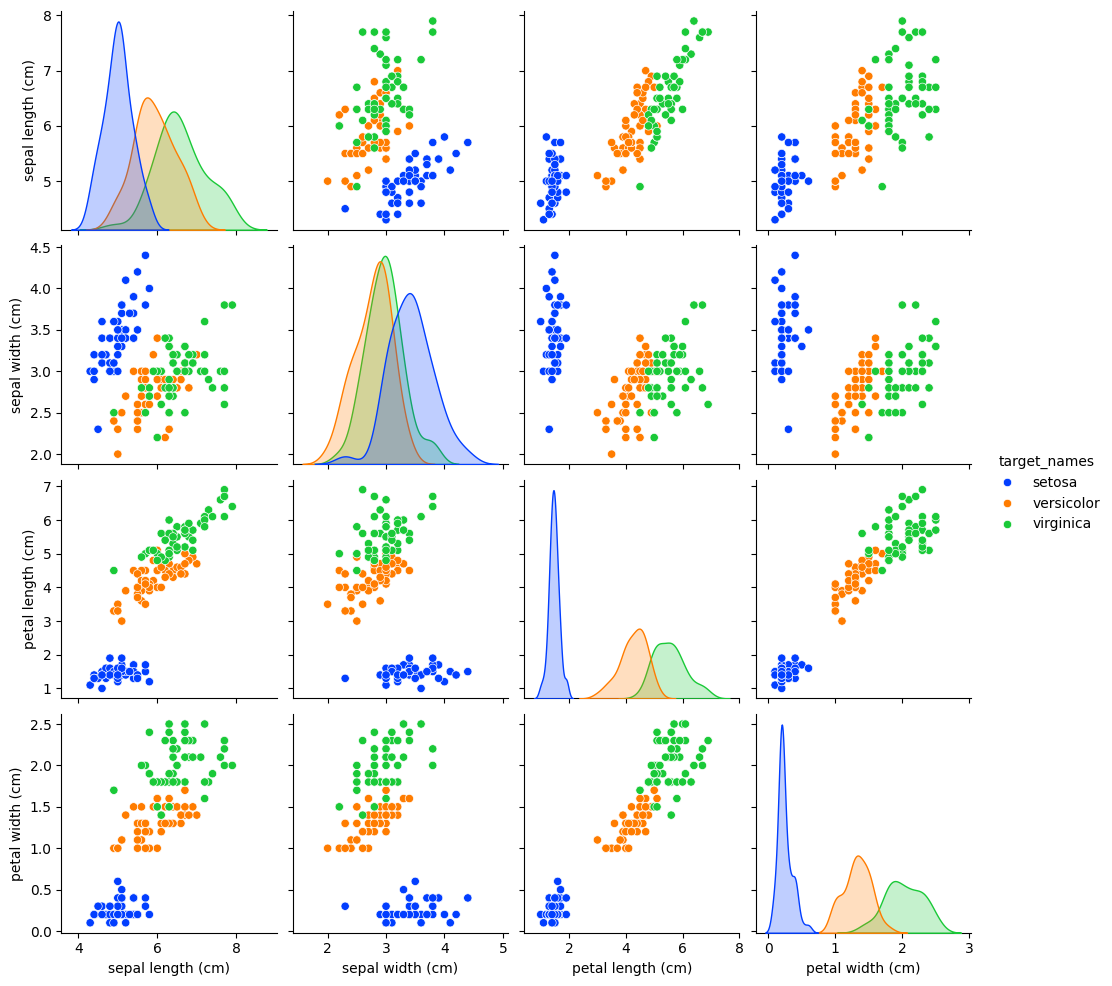

In [3]:
iris = load_iris(as_frame=True)
df = iris.frame
df["target_names"] = iris.target_names[iris.target]
sns.pairplot(df.drop(columns=['target']), hue="target_names", palette="bright")
plt.show()

The setosa class is linearly separable from the _versicolor_ and _virginica classes_.
Therefore, keeping _setosa_ in a binary classification problem would lead to trivial results.
**We thus focus on the _versicolor_ and _virginica_ classes**, which are not linearly separable.This non-linear separability is where quantum kernels become interesting: by leveraging the quantum feature map and the kernel trick, QSVMs can implicitly project classical data into a high-dimensional Hilbert space, potentially capturing complex patterns that are difficult to model with classical kernels.

It can also be observed that the features **_petal length (cm)_ and _petal width (cm)_ are by far the most discriminative** for distinguishing between these two species. Further more, let’s check their coviances among features and class:

Furthermore, let’s check the coviances among features and class by computing the standard correlation coefficient between every pair of attributes:

In [4]:
df = df.query("target_names != 'setosa'")
df = df.drop(columns=["target_names"])
corr_matrix = df.corr()
corr_matrix["target"].sort_values(ascending=False)

target               1.000000
petal width (cm)     0.828129
petal length (cm)    0.786424
sepal length (cm)    0.494305
sepal width (cm)     0.308080
Name: target, dtype: float64

The correlation matrix shows that sepal width is the feature least linearly correlated with the class label.
This does not necessarily mean it is uncorrelated, but rather that its relationship with the target may be non-linear.
To explore this further, we build one dataset using three features and another using all four, and we will later compare their performance.

This choice is also motivated by quantum circuit depth considerations:
including more features increases the number of qubits and entangling operations, which can lead to deeper and more complex circuits.

We decided not to apply PCA in this experiment.The Iris dataset is already low-dimensional, and applying PCA would only create linear combinations of interpretable physical quantities (sepal and petal dimensions).

Since one of the goals of this study is to preserve interpretability, keeping the raw features allows the quantum feature map to capture their joint dependencies while maintaining a more direct connection to the underlying physical variables.

Before we train a model, we split the dataset into two parts. The target labels are mapped from `{1, 2}` to `{−1, +1}` to align with the **theoretical formulation of SVMs** and to correctly compute kernel-based metrics such as the **Kernel Target Alignment (KTA)**.  

In [5]:
X, y = df.drop(columns=["target"]), df.target.replace({1: -1, 2: 1})


from sklearn.model_selection import train_test_split

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, stratify=y, random_state=rd_seed)

### 1.2) Feature selection

In [6]:

feature_sets = {

    "A1": ["petal length (cm)", "petal width (cm)", "sepal length (cm)"],
    "A2": ["petal length (cm)", "petal width (cm)", "sepal length (cm)",  "sepal width (cm)"],

}

## 2. Classical Baseline: SVM with RBF Kernel

Here, I am training classical SVMs to establish a fair benchmark before moving on to the quantum kernels.
I test them on the two feature sets (A1, A2) to assess how much of the separability comes from the data itself versus the expressivity of the kernel.

Because the input features are measured on **different scales**, I apply a **StandardScaler** to normalize them before training to prevents scale dominance.

To make the comparison more robust, I perform cross-validation while tuning the SVM hyperparameters C and γ to provide a more reliable estimate of the model’s generalization ability and allows for a fairer comparison between classical and quantum approaches.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# CV configuration
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=rd_seed)

# parameter grid
param_grid_rbf = {'svm__C' : [1e-3, 1e-2, 0.1, 1, 10, 100], 'svm__gamma' : [1e-3, 1e-2, 0.1, 1, 5, 10]}

results = []  # to store results for all feature sets

for name, cols in feature_sets.items():
    print(f"\nFeature set {name}: {cols}")

    Xtr, Xte = X_train[cols].copy(), X_test[cols].copy()

    # Define pipeline
    pipeline_rbf = Pipeline([("scaler", StandardScaler()), ("svm", SVC(kernel="rbf"))])

    # Grid search (CV on training set)
    grid_rbf = GridSearchCV(pipeline_rbf, param_grid_rbf, cv=cv, scoring="accuracy", n_jobs=-1)
    grid_rbf.fit(Xtr, y_train)

    # Results
    print("\nBest RBF parameters:", grid_rbf.best_params_)
    print(f"Mean CV accuracy: {grid_rbf.best_score_:.3f}")
    test_acc = grid_rbf.score(Xte, y_test)
    print(f"Test accuracy: {test_acc:.3f}")

    # Store results
    results.append((name, grid_rbf.best_params_, grid_rbf.best_score_, test_acc))

    best_model = grid_rbf.best_estimator_
    cv_scores = cross_val_score(best_model, Xtr, y_train, cv=cv)
    print(f"CV stability (mean ± std): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


# Summary of results
res_df = pd.DataFrame(results, columns=["FeatureSet", "BestParams", "CV_Accuracy", "Test_Accuracy"])
display(res_df.style.background_gradient(cmap="Blues", axis=None))


Feature set A1: ['petal length (cm)', 'petal width (cm)', 'sepal length (cm)']

Best RBF parameters: {'svm__C': 0.001, 'svm__gamma': 1}
Mean CV accuracy: 0.962
Test accuracy: 0.850
CV stability (mean ± std): 0.962 ± 0.022

Feature set A2: ['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']

Best RBF parameters: {'svm__C': 1, 'svm__gamma': 0.1}
Mean CV accuracy: 0.962
Test accuracy: 0.900
CV stability (mean ± std): 0.962 ± 0.022


,FeatureSet,BestParams,CV_Accuracy,Test_Accuracy
0,A1,"{'svm__C': 0.001, 'svm__gamma': 1}",0.962500,0.850000
1,A2,"{'svm__C': 1, 'svm__gamma': 0.1}",0.962500,0.900000


Both feature sets achieve the same mean CV accuracy (**0.962 ± 0.022**), showing stable results.  
However, **A2** yields a higher **test accuracy (0.90 vs 0.85)** — indicating slightly better generalization.

- **A1:** `C = 0.001`, `γ = 1`: very strong regularization, local decision boundaries.  
- **A2:** `C = 1`, `γ = 0.1`: smoother kernel, less regularization, better overall balance.

Feature set **A2** performs better on unseen data with more natural RBF parameters, maintaining the same CV stability. Overall, the RBF model captures the decision boundary effectively, leaving limited room for quantum enhancement.

## 3. QSVM — ZZFeatureMap

The **ZZ Feature Map** is the first quantum circuit implemented in this project.  
It encodes classical data into a quantum state by applying rotations (`RZ`) and controlled-Z (`ZZ`) interactions between qubits.  
These pairwise entangling operations capture **correlations between input features**, which is essential for building expressive quantum kernels.  

Before feeding the data into the circuit, I apply a **MinMaxAngleScaler** to map each feature value into an angle between **0 and 2π**.  
This scaling prevents unwanted aliasing effects and improving the overall expressivity of the feature map.

In this implementation, the `ZZFeatureMap` is used within a custom `QuantumKernelTransformer` to compute kernel matrices using either the **SWAP Test** or the **StatevectorSampler**.  

As a rough guideline:  
- A **two-qubit** circuit with a **transpiled depth ≤ 10** is typically **no problem**.  
  Therefore, circuit depths (`reps`) of **1 and 2** are explored to study how increasing entanglement and circuit complexity affect model performance and generalization.  

This represents the **baseline feature map** for our quantum kernel experiments before testing more advanced circuits.

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler
from qiskit.circuit.library import unitary_overlap


class MinMaxAngleScaler(BaseEstimator, TransformerMixin):
    """
    Scales classical features into rotation angles between 0 and a maximum angle (default π or 2π).
    This prevents undesired effects in angle encodings.
    """
    def __init__(self, max_angle=2 * np.pi):
        self.X_max = None
        self.X_min = None
        self.max_angle = max_angle

    def fit(self, X, y=None):
        self.X_max = X.max(axis=0)
        self.X_min = X.min(axis=0)
        return self

    def transform(self, X):
        if self.X_min is None or self.X_max is None:
            raise ValueError("Scaler must be fit before transform.")
        denom = self.X_max - self.X_min
        denom[denom == 0] = 1
        return (X - self.X_min) / denom * self.max_angle


class QuantumKernelTransformer(BaseEstimator, TransformerMixin):
    """
    Quantum kernel transformer supporting two exact modes:
      - 'statevector': 
      - 'sampler': overlap estimated via StatevectorSampler (noiseless, measured)
    """
    def __init__(self, feature_map, mode="statevector"):
        self.feature_map = feature_map
        self.mode = mode
        self.X_train_ = None
        self.K_train_ = None

    def compute_kernel(self, X_1, X_2):
        fm = self.feature_map
        n_1, n_2 = X_1.shape[0], X_2.shape[0]
        kernel = np.zeros((n_1, n_2))
        same_matrix = np.array_equal(X_1, X_2)

        # Prepare sampler if needed
        sampler = StatevectorSampler() if self.mode == "sampler" else None

        for i in range(n_1):
            circ_i = fm.assign_parameters(X_1.iloc[i])
            j_start = i if same_matrix else 0

            for j in range(j_start, n_2):
                circ_j = fm.assign_parameters(X_2.iloc[j])
                overlap_circ = unitary_overlap(circ_i, circ_j)

                # Mode-dependent computation
                if self.mode == "sampler":
                    overlap_circ.measure_all()
                    results = sampler.run([overlap_circ], shots=10_000).result()
                    counts = results[0].data.meas.get_int_counts()
                    total = sum(counts.values())
                    prob_0 = counts.get(0, 0.0) / total if total > 0 else 0.0

                elif self.mode == "statevector":
                    # Analytic overlap
                    sv_i = Statevector(circ_i)
                    sv_j = Statevector(circ_j)
                    prob_0 = np.abs(sv_i.data.conj().T @ sv_j.data) ** 2

                else:
                    raise ValueError("Mode must be 'statevector' or 'sampler'.")

                kernel[i, j] = prob_0
                if same_matrix and i != j:
                    kernel[j, i] = prob_0

        return kernel

    def fit(self, X, y=None):
        self.X_train_ = X
        self.K_train_ = self.compute_kernel(X, X)
        return self

    def transform(self, X):
        if np.array_equal(X, self.X_train_):
            return self.K_train_
        else:
            return self.compute_kernel(X, self.X_train_)



A1 | reps=1 | depth=8 | #CX=4
Best C: 0.001, CV acc: 0.712, Test acc: 0.500
CV stability (mean ± std): 0.712 ± 0.119

A1 | reps=2 | depth=16 | #CX=8
Best C: 100, CV acc: 0.650, Test acc: 0.600
CV stability (mean ± std): 0.650 ± 0.087

A2 | reps=1 | depth=11 | #CX=6
Best C: 1, CV acc: 0.638, Test acc: 0.600
CV stability (mean ± std): 0.638 ± 0.114

A2 | reps=2 | depth=19 | #CX=12
Best C: 10, CV acc: 0.512, Test acc: 0.700
CV stability (mean ± std): 0.512 ± 0.041


,FeatureSet,Reps,Depth,CX,CV_Acc,Test_Acc
0,A1,1,8,4,0.712500,0.500000
1,A1,2,16,8,0.650000,0.600000
2,A2,1,11,6,0.637500,0.600000
3,A2,2,19,12,0.512500,0.700000


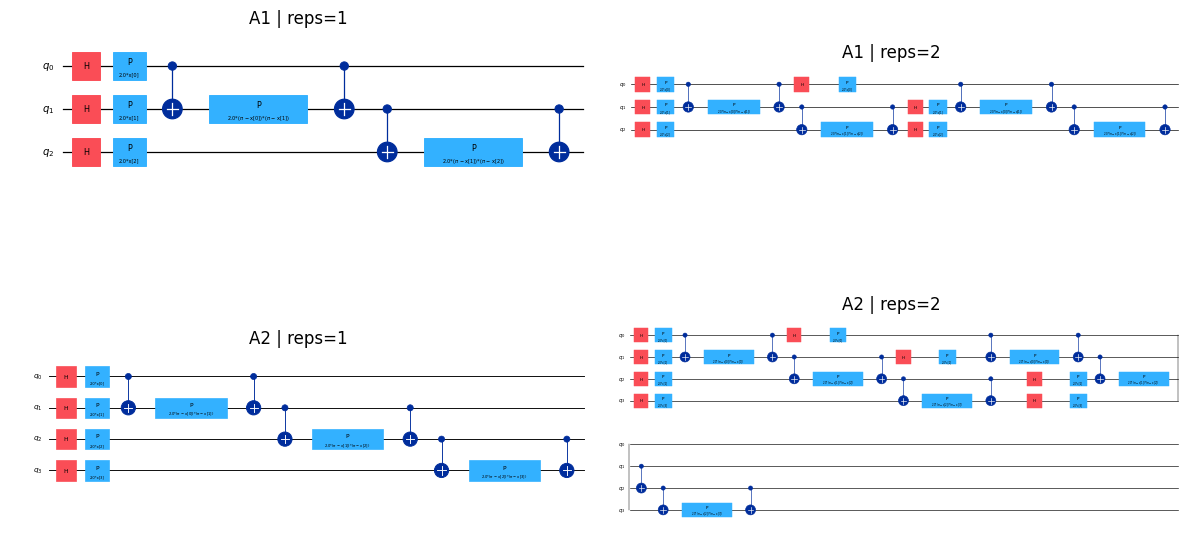

In [10]:
from qiskit.circuit.library import ZZFeatureMap

param_grid_qke = {'svm__C': [1e-3, 1e-2, 0.1, 1, 10, 100]}
reps_list = [1, 2] 

results_qke = []
# store circuits for later visualization
circuits_to_plot = []

for name, cols in feature_sets.items():
    Xtr, Xte = X_train[cols].copy(), X_test[cols].copy()
    n_features = len(cols)

    for reps in reps_list:

        fm = ZZFeatureMap(feature_dimension=n_features, entanglement='linear', reps=reps)
        depth = fm.decompose().depth()
        cx = fm.decompose().count_ops().get("cx", 0)

        circuits_to_plot.append((f"{name} | reps={reps}", fm))


        print(f"\n{name} | reps={reps} | depth={depth} | #CX={cx}")

        pipeline_qke = Pipeline([
            ("scaler", MinMaxAngleScaler()),
            ("quantum_kernel", QuantumKernelTransformer(feature_map=fm)),
            ("svm", SVC(kernel="precomputed"))
        ])

        grid_qke = GridSearchCV(
            pipeline_qke,
            param_grid_qke,
            cv=cv,
            scoring="accuracy",
            n_jobs=-1
        )
        grid_qke.fit(Xtr, y_train)
        test_acc = grid_qke.score(Xte, y_test)

        print(f"Best C: {grid_qke.best_params_['svm__C']}, CV acc: {grid_qke.best_score_:.3f}, Test acc: {test_acc:.3f}")
        # CV stability
        best_model = grid_qke.best_estimator_
        cv_scores = cross_val_score(best_model, Xtr, y_train, cv=cv)
        print(f"CV stability (mean ± std): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
        
        results_qke.append((name, reps, depth, cx, grid_qke.best_score_, test_acc))

res_qke_df = pd.DataFrame(results_qke, columns=["FeatureSet", "Reps", "Depth", "CX", "CV_Acc", "Test_Acc"])
display(res_qke_df.style.background_gradient(cmap="Purples", axis=None))

- Increasing the circuit repetitions (`reps`) from 1 to 2 systematically **increases circuit depth and entanglement**, but does **not consistently improve performance**.  
  In fact, deeper circuits often show **lower CV accuracy**, suggesting possible **overparameterization** or **loss of generalization**.

- The **A1 feature set** (3 features) yields slightly higher cross-validation accuracy overall, but its test accuracy remains limited (≤ 0.6).  
  This indicates that the model might be **overfitting the training folds** or that the **feature map expressivity** is insufficient for the dataset.

- The **A2 feature set** (4 features) does not clearly outperform A1.  
  The result for `A2 | reps=2` shows a higher test accuracy (0.70) but a much lower CV mean (0.51), implying **instability and poor consistency** across folds.

- The increasing **CV standard deviation** for shallower circuits (`±0.11–0.12`) reflects **high variability** across folds, confirming that the model’s performance is sensitive to data partitioning.


## 4. QSVM — Custom Re-uploading Feature Map

To go beyond the fixed structure of the **ZZ Feature Map**, a **custom data re-uploading feature map** is implemented.  
This approach introduces **parameterized rotations and repeated data encoding layers**, allowing the circuit to capture more **nonlinear relationships** between features while maintaining control over circuit depth and entanglement.

The feature map is built from the following key components:

1. **Global basis rotation**: a shared `RY(θ)` layer applied to all qubits, controlled by a fixed parameter `θ`.  
   This introduces a global tilt of the computational basis, enriching the representational capacity.

2. **Entanglement layer**: nearest-neighbor entangling gates, controlled by the `entangler` argument.  

3. **Data re-uploading**: each feature is encoded multiple times via parameterized rotations `RY(-2x)` and `RZ(-2x)`.  
   Re-uploading (`L` layers) allows the circuit to **reuse and transform the same data** across multiple nonlinear layers, similar to how hidden layers in a neural network build hierarchical representations.


Unlike the **ZZFeatureMap**, which encodes each feature only once and relies purely on pairwise entanglement,  
this custom map introduces **repeated encoding and tunable global rotations**, offering greater **expressivity** and **nonlinearity** in the feature space.

**Note**:
P. Rodriguez-Grasa, Y. Ban, M. Sanz, *Data re-uploaded quantum kernels for support vector machine*, University of the Basque Country, June 2023

In [11]:
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

# Build a custom re-uploading feature map 

def custom_map(n_features, theta=np.pi/2, L=2, entangler='cx'):

    n_qubits = n_features 
    qc = QuantumCircuit(n_qubits)

    thetap = Parameter("θ")
    fvec = ParameterVector("x", n_features) 

    for _ in range(L):
        # global basis tilt
        qc.ry(thetap, qc.qubits)

        # entanglement (linear)
        for q in range(n_qubits - 1):
            if entangler == 'cx':
                qc.cx(q, q + 1)
            else:
                qc.cz(q, q + 1)

        # data re-upload
        for q in range(n_qubits):
            qc.ry(-2 * fvec[q], q)
            qc.rz(-2 * fvec[q], q)

    # bind fixed theta so only 'x' remain free
    qc = qc.assign_parameters({thetap: theta})
    return qc


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import numpy as np
import pandas as pd

param_grid_qsvmB = {'svm__C': [0.1, 1, 10]}
thetas = [np.pi/4, np.pi/2]  
Ls = [1,2]                      # 2 layer max. to limit circuit depth
entanglers = ['cx']           # only one entanglement type is tested here
results_qsvmB = []

for name, cols in feature_sets.items():
    Xtr, Xte = X_train[cols].copy(), X_test[cols].copy()
    n_features = len(cols)

    for L in Ls:
        for theta in thetas:
            for ent in entanglers:
                # Create the feature map
                fmB = custom_map(n_features, theta=theta, L=L, entangler=ent)

                # Get circuit metrics
                depth = fmB.decompose().depth()
                cx = fmB.decompose().count_ops().get("cx", 0)

                # Build the pipeline
                pipeline_qsvmB = Pipeline([
                    ("scaler", MinMaxAngleScaler(max_angle=np.pi)),
                    ("quantum_kernel", QuantumKernelTransformer(feature_map=fmB)),
                    ("svm", SVC(kernel="precomputed"))
                ])

                # Cross-validation
                gridB = GridSearchCV(
                    pipeline_qsvmB,
                    param_grid_qsvmB,
                    cv=cv,
                    scoring="accuracy",
                    n_jobs=-1,
                    return_train_score=True
                )
                gridB.fit(Xtr, y_train)
                test_acc = gridB.score(Xte, y_test)

                # Compute mean and std of CV results
                mean_cv = gridB.cv_results_['mean_test_score'].mean()
                std_cv = gridB.cv_results_['std_test_score'].mean()

                print(f"{name} | L={L} θ={theta:.2f} ent={ent} | "
                      f"depth={depth} CX={cx} | "
                      f"CV_mean={mean_cv:.3f}±{std_cv:.3f} | Test={test_acc:.3f}")

                results_qsvmB.append((name, L, float(theta), ent, depth, cx,
                                      mean_cv, std_cv, test_acc))

# Results summary
res_qsvmB_df = pd.DataFrame(
    results_qsvmB,
    columns=["FeatureSet", "L", "Theta", "Entanglement",
             "Depth", "CX", "CV_Mean", "CV_Std", "Test_Accuracy"]
)
display(res_qsvmB_df.style.background_gradient(cmap="Greens", axis=None))


A1 | L=1 θ=0.79 ent=cx | depth=5 CX=2 | CV_mean=0.904±0.068 | Test=0.900
A1 | L=1 θ=1.57 ent=cx | depth=5 CX=2 | CV_mean=0.938±0.046 | Test=0.850
A1 | L=2 θ=0.79 ent=cx | depth=10 CX=4 | CV_mean=0.796±0.072 | Test=0.850
A1 | L=2 θ=1.57 ent=cx | depth=10 CX=4 | CV_mean=0.821±0.067 | Test=0.800
A2 | L=1 θ=0.79 ent=cx | depth=6 CX=3 | CV_mean=0.875±0.062 | Test=0.900
A2 | L=1 θ=1.57 ent=cx | depth=6 CX=3 | CV_mean=0.929±0.041 | Test=0.800
A2 | L=2 θ=0.79 ent=cx | depth=11 CX=6 | CV_mean=0.804±0.086 | Test=0.700
A2 | L=2 θ=1.57 ent=cx | depth=11 CX=6 | CV_mean=0.792±0.140 | Test=0.850


,FeatureSet,L,Theta,Entanglement,Depth,CX,CV_Mean,CV_Std,Test_Accuracy
0,A1,1,0.785398,cx,5,2,0.904167,0.068415,0.900000
1,A1,1,1.570796,cx,5,2,0.937500,0.046263,0.850000
2,A1,2,0.785398,cx,10,4,0.795833,0.072448,0.850000
3,A1,2,1.570796,cx,10,4,0.820833,0.067463,0.800000
4,A2,1,0.785398,cx,6,3,0.875000,0.062491,0.900000
5,A2,1,1.570796,cx,6,3,0.929167,0.040787,0.800000
6,A2,2,0.785398,cx,11,6,0.804167,0.086357,0.700000
7,A2,2,1.570796,cx,11,6,0.791667,0.140256,0.850000


- From the results, we can see that depth beyond L = 1 doesn’t help.
The 2-layer circuits (depth = 10–11) consistently yield lower CV accuracy and larger variance, which is a clear sign of over-parameterization relative to dataset size.

- θ = π/2 gives more expressive kernels, but that expressivity isn’t always beneficial. Test scores tend to drop slightly when the kernel becomes too complex.

- The second feature set (A2) adds another variable but does not significantly improve accuracy. In fact, A1 (L = 1, θ = π/2) and A2 (L = 1, θ = π/4) achieve similar test scores (~0.85–0.9). The fourth feature (in A2) seems to contribute little to predictive power, it likely introduces noise more than useful structure.

- The ZZ map often has stronger built-in entanglement. In small-feature problems, the ZZ kernel may overfit faster.

## 5. Expressivity analysis

Let’s analyze the expressivity of the A1 | L = 1 | θ = π/2 | ent = cx circuit, the best overall cross-validated model, and compare it with the ZZFeatureMap.

Following Gross et al. (2025), “Expressivity vs. Generalization in Quantum Kernel Methods”, the expressivity of a quantum feature map can be assessed by studying the eigenvalue spectrum of its kernel matrix.

A broader spectrum, meaning more non-zero eigenvalues, indicates that the feature map produces more diverse quantum embeddings in Hilbert space, leading to higher expressivity.

A narrow or concentrated spectrum, where a few eigenvalues dominate, reflects a simplicity bias, meaning the circuit primarily captures smooth, low-frequency patterns and may generalize better but with reduced expressivity.

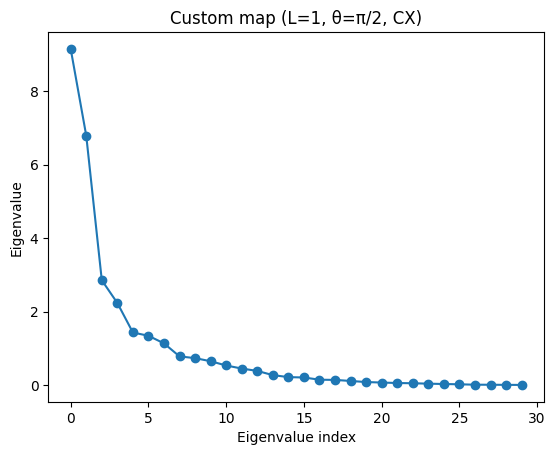

Non-zero eigenvalues: 30 / 30
Energy in top 10% eigenvalues: 0.626



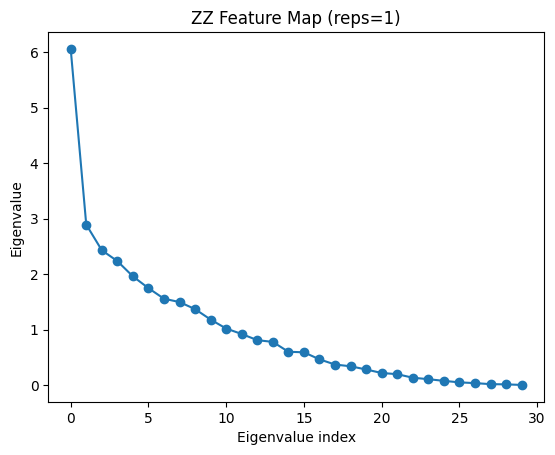

Non-zero eigenvalues: 30 / 30
Energy in top 10% eigenvalues: 0.379



In [20]:
# Data
X_small = X_train[feature_sets["A1"]].iloc[:30].copy()
scaler = MinMaxAngleScaler(max_angle=np.pi).fit(X_small)
X_scaled = scaler.transform(X_small)

# Build both feature maps
fm_custom = custom_map(len(feature_sets["A1"]), theta=np.pi/2, L=1, entangler='cx')
fm_zz = ZZFeatureMap(feature_dimension=len(feature_sets["A1"]), reps=1, entanglement='linear')

# Compute kernels
qk_custom = QuantumKernelTransformer(feature_map=fm_custom)
K_custom = qk_custom.fit_transform(X_scaled)
qk_zz = QuantumKernelTransformer(feature_map=fm_zz)
K_zz = qk_zz.fit_transform(X_scaled)

# Function for eigenspectrum analysis
def plot_kernel_spectrum(K, title):
    eigvals = np.linalg.eigvalsh(K)
    eigvals = np.sort(eigvals)[::-1]
    plt.plot(eigvals, 'o-')
    plt.title(title)
    plt.xlabel("Eigenvalue index")
    plt.ylabel("Eigenvalue")
    plt.show()
    nz = (eigvals > 1e-6).sum()
    energy_top10 = eigvals[:int(0.1*len(eigvals))].sum() / eigvals.sum()
    print(f"Non-zero eigenvalues: {nz} / {len(eigvals)}")
    print(f"Energy in top 10% eigenvalues: {energy_top10:.3f}\n")

# Comparison
plot_kernel_spectrum(K_custom, "Custom map (L=1, θ=π/2, CX)")
plot_kernel_spectrum(K_zz, "ZZ Feature Map (reps=1)")

Custom data re-uploading map:
- The spectrum is moderately concentrated: a few dominant modes capture most of the variance. This indicates controlled expressivity. 
    The circuit generates diverse embeddings while keeping a useful bias toward smoother functions, which supports stable generalization.

ZZFeatureMap:
- The spectrum is flatter and more evenly distributed, meaning higher expressivity and a more complex feature space.

Although the ZZFeatureMap is more expressive, its broader spectrum likely causes overfitting given the dataset size.
The custom circuit, being less expressive but more structured, achieves better alignment with the data distribution, leading to higher and more stable performance.